In [ ]:
#  Análisis Exploratorio - NYC Taxi Sample Data
## UrbanFlow Predictor - Análisis Inicial de Datos

In [ ]:
# Configuración inicial CORREGIDA para Windows 
import sys
import os
sys.path.append('../')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configurar visualizaciones
plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline

print(" Librerías básicas importadas correctamente")

# Intentar importar PySpark con configuración especial para Windows
try:
    from pyspark.sql import SparkSession
    import os
    
    # Configuración especial para Windows
    os.environ['PYSPARK_SUBMIT_ARGS'] = '--master local[2] pyspark-shell'
    os.environ['HADOOP_HOME'] = ''  # Deshabilitar Hadoop en Windows
    
    # Crear SparkSession con configuración específica
    spark = SparkSession.builder \
        .appName("EDA_NYC_Taxi") \
        .config("spark.sql.adaptive.enabled", "true") \
        .config("spark.master", "local[2]") \
        .config("spark.sql.warehouse.dir", "file:///C:/temp/") \
        .config("spark.driver.extraJavaOptions", "-Djava.security.manager=allow") \
        .config("spark.driver.bindAddress", "127.0.0.1") \
        .getOrCreate()
    
    spark.sparkContext.setLogLevel("WARN")
    print(" Spark session iniciada exitosamente en Windows")
    
except Exception as e:
    print(f"  No se pudo iniciar Spark: {e}")
    print(" Continuando con análisis usando solo Pandas...")
    spark = None


✅ Librerías básicas importadas correctamente
⚠️  No se pudo iniciar Spark: An error occurred while calling None.org.apache.spark.api.java.JavaSparkContext.
: java.lang.UnsupportedOperationException: getSubject is supported only if a security manager is allowed
	at java.base/javax.security.auth.Subject.getSubject(Subject.java:347)
	at org.apache.hadoop.security.UserGroupInformation.getCurrentUser(UserGroupInformation.java:588)
	at org.apache.spark.util.Utils$.$anonfun$getCurrentUserName$1(Utils.scala:2446)
	at scala.Option.getOrElse(Option.scala:201)
	at org.apache.spark.util.Utils$.getCurrentUserName(Utils.scala:2446)
	at org.apache.spark.SparkContext.<init>(SparkContext.scala:339)
	at org.apache.spark.api.java.JavaSparkContext.<init>(JavaSparkContext.scala:59)
	at java.base/jdk.internal.reflect.DirectConstructorHandleAccessor.newInstance(DirectConstructorHandleAccessor.java:62)
	at java.base/java.lang.reflect.Constructor.newInstanceWithCaller(Constructor.java:501)
	at java.base/java.l

In [14]:
# Cargar datos procesados
def load_processed_data():
    """Cargar todos los datos procesados"""
    
    data_paths = {
        'raw_data': '../data/raw/yellow_tripdata_2015-01_sample.csv',
        'business_metrics': '../data/processed/business_metrics.json'
    }
    
    data = {}
    
    # Cargar datos principales
    if os.path.exists(data_paths['raw_data']):
        data['df'] = pd.read_csv(data_paths['raw_data'])
        print(f" Datos cargados: {len(data['df'])} registros")
        
        # Convertir fechas
        data['df']['tpep_pickup_datetime'] = pd.to_datetime(data['df']['tpep_pickup_datetime'])
        data['df']['tpep_dropoff_datetime'] = pd.to_datetime(data['df']['tpep_dropoff_datetime'])
        
    else:
        print(" No se encontraron datos. Ejecuta: python run_etl.py")
        return None
    
    # Cargar métricas de negocio
    if os.path.exists(data_paths['business_metrics']):
        with open(data_paths['business_metrics'], 'r') as f:
            data['business_metrics'] = json.load(f)
        print(" Métricas de negocio cargadas")
    
    return data

# Cargar datos
data = load_processed_data()
if data is not None:
    df = data['df']
    print("\n Primeras filas del dataset:")
    display(df.head(3))

 Datos cargados: 1000 registros

 Primeras filas del dataset:


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,1,2015-01-07 19:28:00,2015-01-07 19:47:00,3,3.54,-73.932161,40.759866,1,N,-73.923838,40.740689,3,10.42,0.5,0.5,0.44,0.0,0.3,12.16
1,2,2015-01-21 00:11:00,2015-01-21 01:13:00,4,6.18,-73.957029,40.743195,3,N,-73.973405,40.747930,1,21.57,1.0,0.5,2.01,5.0,0.3,30.38
2,2,2015-01-07 20:08:00,2015-01-07 20:51:00,5,11.48,-74.018408,40.794220,1,N,-74.011078,40.798620,2,32.56,0.0,0.5,2.55,0.0,0.3,35.91


In [16]:
# Análisis básico
if 'df' in locals():
    print(" ESTADÍSTICAS BÁSICAS DEL DATASET")
    print("=" * 50)
    print(f"Total registros: {len(df):,}")
    print(f"Período: {df['tpep_pickup_datetime'].min()} to {df['tpep_pickup_datetime'].max()}")
    print(f"Columnas disponibles: {len(df.columns)}")
    print(f"Columnas: {list(df.columns)}")
    
    # Estadísticas numéricas
    numeric_cols = ['trip_distance', 'fare_amount', 'tip_amount', 'total_amount', 'passenger_count']
    print("\n Estadísticas descriptivas:")
    display(df[numeric_cols].describe())
    
    # Información de tipos de datos
    print("\n Información de tipos de datos:")
    print(df.dtypes)


 ESTADÍSTICAS BÁSICAS DEL DATASET
Total registros: 1,000
Período: 2015-01-01 00:27:00 to 2015-01-31 23:09:00
Columnas disponibles: 19
Columnas: ['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 'pickup_longitude', 'pickup_latitude', 'RateCodeID', 'store_and_fwd_flag', 'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount']

 Estadísticas descriptivas:


,trip_distance,fare_amount,tip_amount,total_amount,passenger_count
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,10.152660,30.428260,3.064090,35.730350,3.485000
std,5.604347,14.370228,2.439375,16.174152,1.692525
min,0.510000,2.500000,0.000000,3.420000,1.000000
25%,5.435000,18.417500,1.075000,22.565000,2.000000
50%,10.085000,30.625000,2.470000,36.060000,3.000000
75%,14.912500,42.262500,4.522500,48.955000,5.000000
max,19.970000,59.620000,10.800000,72.490000,6.000000



 Información de tipos de datos:
VendorID                          int64
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                   int64
trip_distance                   float64
pickup_longitude                float64
pickup_latitude                 float64
RateCodeID                        int64
store_and_fwd_flag               object
dropoff_longitude               float64
dropoff_latitude                float64
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
dtype: object


In [18]:
# Feature Engineering con Pandas
if 'df' in locals():
    print(" Aplicando Feature Engineering...")
    
    # Características temporales
    df['pickup_hour'] = df['tpep_pickup_datetime'].dt.hour
    df['pickup_day'] = df['tpep_pickup_datetime'].dt.day_name()
    df['pickup_day_num'] = df['tpep_pickup_datetime'].dt.dayofweek
    df['is_weekend'] = df['pickup_day_num'].isin([5, 6]).astype(int)
    
    # Duración del viaje
    df['trip_duration_minutes'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds() / 60
    df['trip_duration_minutes'] = df['trip_duration_minutes'].round(2)
    
    # Características de tarifas
    df['fare_per_mile'] = (df['fare_amount'] / df['trip_distance']).round(2)
    df['fare_per_mile'] = df['fare_per_mile'].replace([np.inf, -np.inf], 0)
    
    df['tip_percentage'] = ((df['tip_amount'] / df['fare_amount']) * 100).round(2)
    df['tip_percentage'] = df['tip_percentage'].replace([np.inf, -np.inf], 0)
    
    # Velocidad promedio
    df['avg_speed_mph'] = (df['trip_distance'] / (df['trip_duration_minutes'] / 60)).round(2)
    df['avg_speed_mph'] = df['avg_speed_mph'].replace([np.inf, -np.inf], 0)
    
    # Zona horaria
    df['time_of_day'] = pd.cut(df['pickup_hour'], 
                              bins=[0, 6, 12, 18, 24],
                              labels=['night', 'morning', 'afternoon', 'evening'],
                              include_lowest=True)
    
    print(" Feature engineering completado")
    print(f"Nuevas columnas: {[col for col in df.columns if col not in numeric_cols]}")

 Aplicando Feature Engineering...
 Feature engineering completado
Nuevas columnas: ['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'pickup_longitude', 'pickup_latitude', 'RateCodeID', 'store_and_fwd_flag', 'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'extra', 'mta_tax', 'tolls_amount', 'improvement_surcharge', 'pickup_hour', 'pickup_day', 'pickup_day_num', 'is_weekend', 'trip_duration_minutes', 'fare_per_mile', 'tip_percentage', 'avg_speed_mph', 'time_of_day']


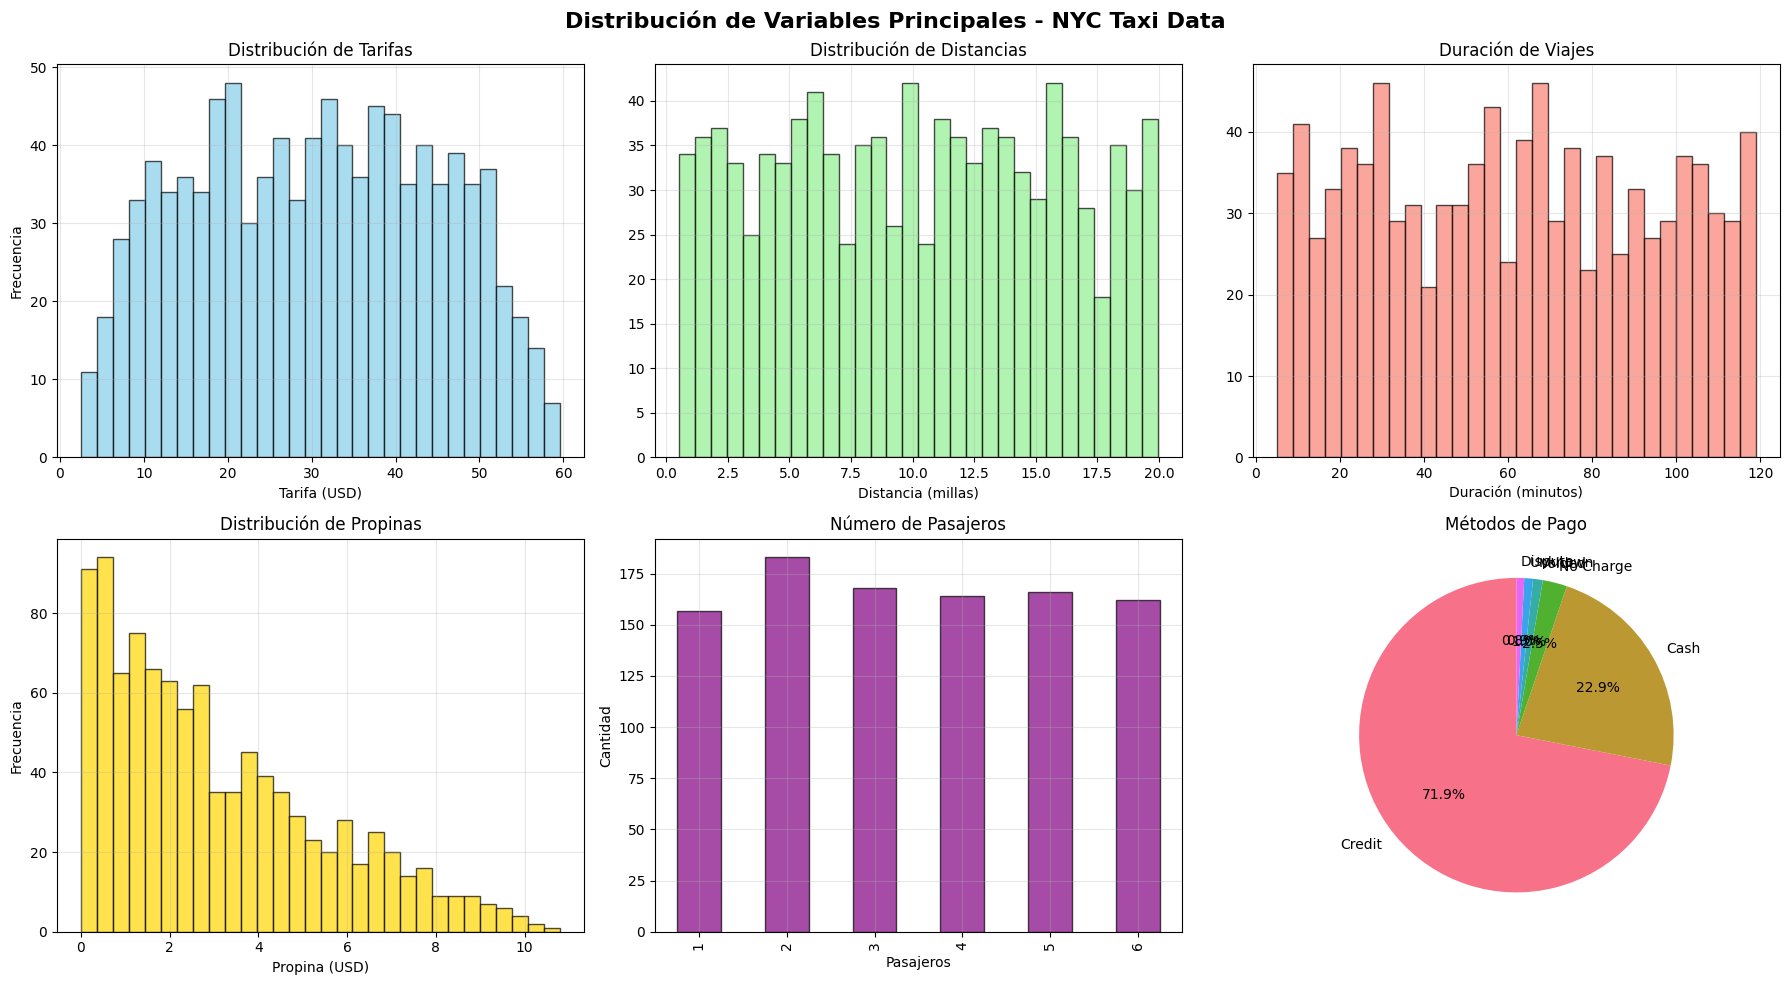

In [19]:
# Visualizaciones de distribución
if 'df' in locals():
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('Distribución de Variables Principales - NYC Taxi Data', fontsize=16, fontweight='bold')
    
    # Distribución de tarifas
    axes[0,0].hist(df['fare_amount'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0,0].set_title('Distribución de Tarifas')
    axes[0,0].set_xlabel('Tarifa (USD)')
    axes[0,0].set_ylabel('Frecuencia')
    axes[0,0].grid(True, alpha=0.3)
    
    # Distribución de distancias
    axes[0,1].hist(df['trip_distance'], bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
    axes[0,1].set_title('Distribución de Distancias')
    axes[0,1].set_xlabel('Distancia (millas)')
    axes[0,1].grid(True, alpha=0.3)
    
    # Distribución de duraciones
    axes[0,2].hist(df['trip_duration_minutes'], bins=30, alpha=0.7, color='salmon', edgecolor='black')
    axes[0,2].set_title('Duración de Viajes')
    axes[0,2].set_xlabel('Duración (minutos)')
    axes[0,2].grid(True, alpha=0.3)
    
    # Distribución de propinas
    axes[1,0].hist(df['tip_amount'], bins=30, alpha=0.7, color='gold', edgecolor='black')
    axes[1,0].set_title('Distribución de Propinas')
    axes[1,0].set_xlabel('Propina (USD)')
    axes[1,0].set_ylabel('Frecuencia')
    axes[1,0].grid(True, alpha=0.3)
    
    # Pasajeros
    df['passenger_count'].value_counts().sort_index().plot(kind='bar', ax=axes[1,1], 
                                                         color='purple', alpha=0.7, edgecolor='black')
    axes[1,1].set_title('Número de Pasajeros')
    axes[1,1].set_xlabel('Pasajeros')
    axes[1,1].set_ylabel('Cantidad')
    axes[1,1].grid(True, alpha=0.3)
    
    # Método de pago
    payment_map = {1: 'Credit', 2: 'Cash', 3: 'No Charge', 4: 'Dispute', 5: 'Unknown', 6: 'Voided'}
    payment_data = df['payment_type'].map(lambda x: payment_map.get(x, 'Unknown'))
    payment_data.value_counts().plot(kind='pie', ax=axes[1,2], autopct='%1.1f%%', startangle=90)
    axes[1,2].set_title('Métodos de Pago')
    axes[1,2].set_ylabel('')
    
    plt.tight_layout()
    plt.show()

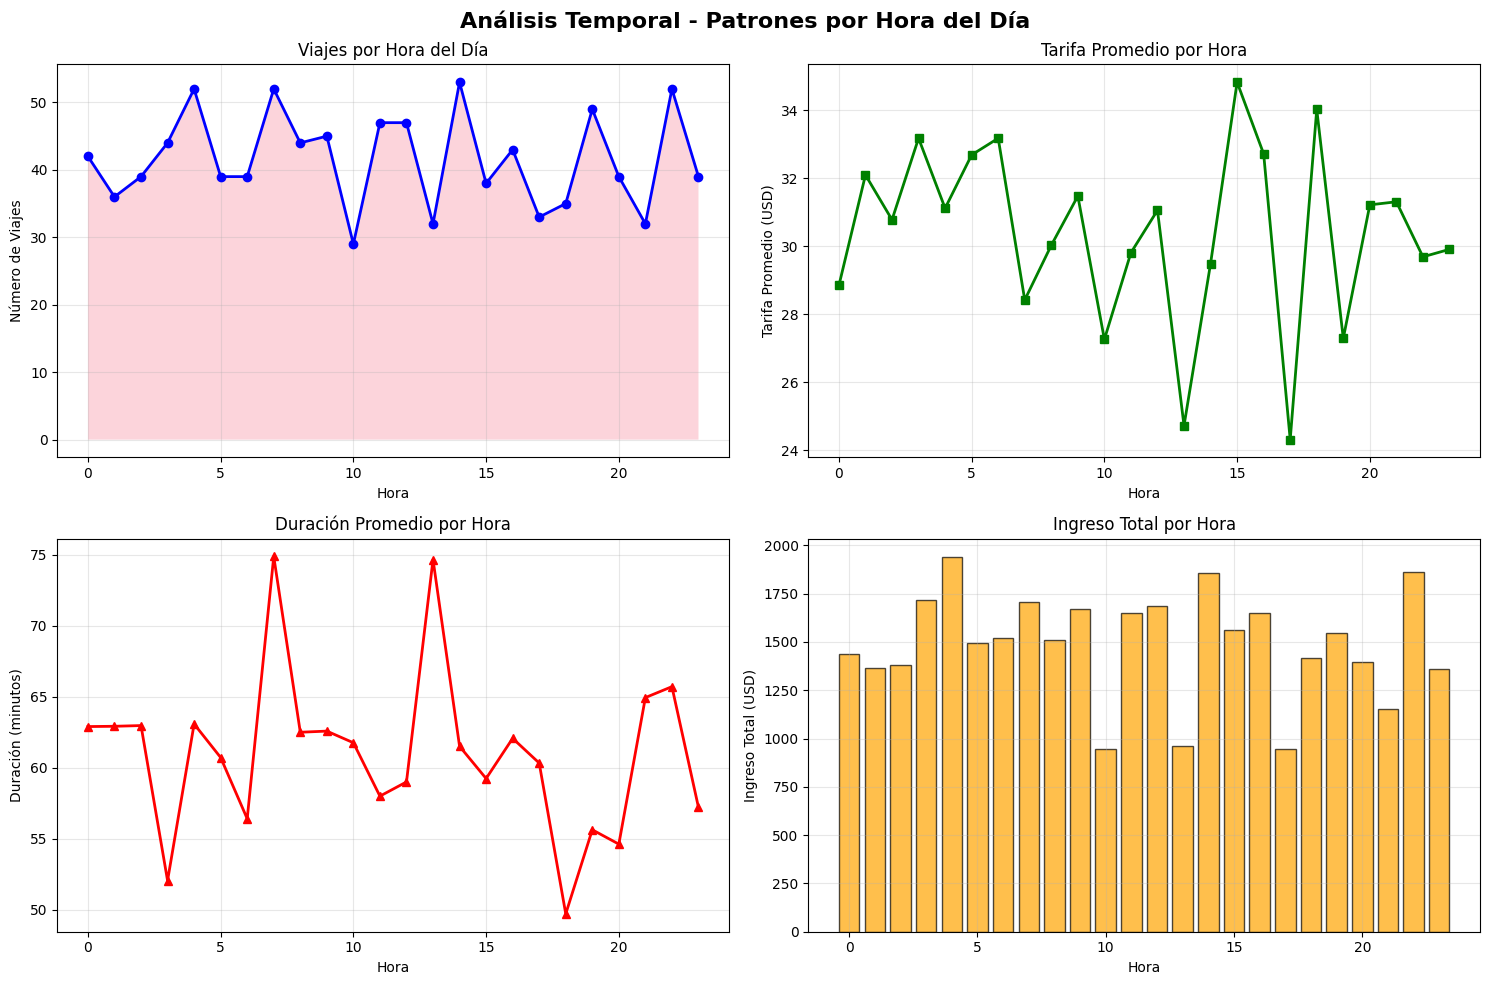

 Métricas por Hora del Día:


,pickup_hour,trip_count,avg_fare,total_revenue,avg_duration,avg_tip
0,0,42,28.85,1436.73,62.90,3.24
1,1,36,32.10,1363.00,62.92,3.36
2,2,39,30.78,1379.45,62.97,2.96
3,3,44,33.18,1717.36,52.05,3.48
4,4,52,31.12,1937.79,63.08,2.97
5,5,39,32.69,1491.75,60.72,3.45
6,6,39,33.18,1519.21,56.41,3.26
7,7,52,28.42,1706.74,74.88,2.58
8,8,44,30.03,1512.32,62.50,2.94
9,9,45,31.48,1670.00,62.58,3.44


In [22]:
# Análisis temporal
if 'df' in locals():
    # Métricas por hora
    hourly_stats = df.groupby('pickup_hour').agg({
        'trip_distance': 'count',
        'fare_amount': 'mean',
        'total_amount': 'sum',
        'trip_duration_minutes': 'mean',
        'tip_amount': 'mean'
    }).rename(columns={
        'trip_distance': 'trip_count',
        'fare_amount': 'avg_fare',
        'total_amount': 'total_revenue',
        'trip_duration_minutes': 'avg_duration',
        'tip_amount': 'avg_tip'
    }).round(2).reset_index()

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Análisis Temporal - Patrones por Hora del Día', fontsize=16, fontweight='bold')
    
    # Viajes por hora
    axes[0,0].plot(hourly_stats['pickup_hour'], hourly_stats['trip_count'], 
                   marker='o', linewidth=2, markersize=6, color='blue')
    axes[0,0].set_title('Viajes por Hora del Día')
    axes[0,0].set_xlabel('Hora')
    axes[0,0].set_ylabel('Número de Viajes')
    axes[0,0].grid(True, alpha=0.3)
    axes[0,0].fill_between(hourly_stats['pickup_hour'], hourly_stats['trip_count'], alpha=0.3)
    
    # Tarifa promedio por hora
    axes[0,1].plot(hourly_stats['pickup_hour'], hourly_stats['avg_fare'], 
                   marker='s', color='green', linewidth=2, markersize=6)
    axes[0,1].set_title('Tarifa Promedio por Hora')
    axes[0,1].set_xlabel('Hora')
    axes[0,1].set_ylabel('Tarifa Promedio (USD)')
    axes[0,1].grid(True, alpha=0.3)
    
    # Duración promedio por hora
    axes[1,0].plot(hourly_stats['pickup_hour'], hourly_stats['avg_duration'], 
                   marker='^', color='red', linewidth=2, markersize=6)
    axes[1,0].set_title('Duración Promedio por Hora')
    axes[1,0].set_xlabel('Hora')
    axes[1,0].set_ylabel('Duración (minutos)')
    axes[1,0].grid(True, alpha=0.3)
    
    # Ingreso total por hora
    axes[1,1].bar(hourly_stats['pickup_hour'], hourly_stats['total_revenue'], 
                  color='orange', alpha=0.7, edgecolor='black')
    axes[1,1].set_title('Ingreso Total por Hora')
    axes[1,1].set_xlabel('Hora')
    axes[1,1].set_ylabel('Ingreso Total (USD)')
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Mostrar tabla de métricas horarias
    print(" Métricas por Hora del Día:")
    display(hourly_stats)

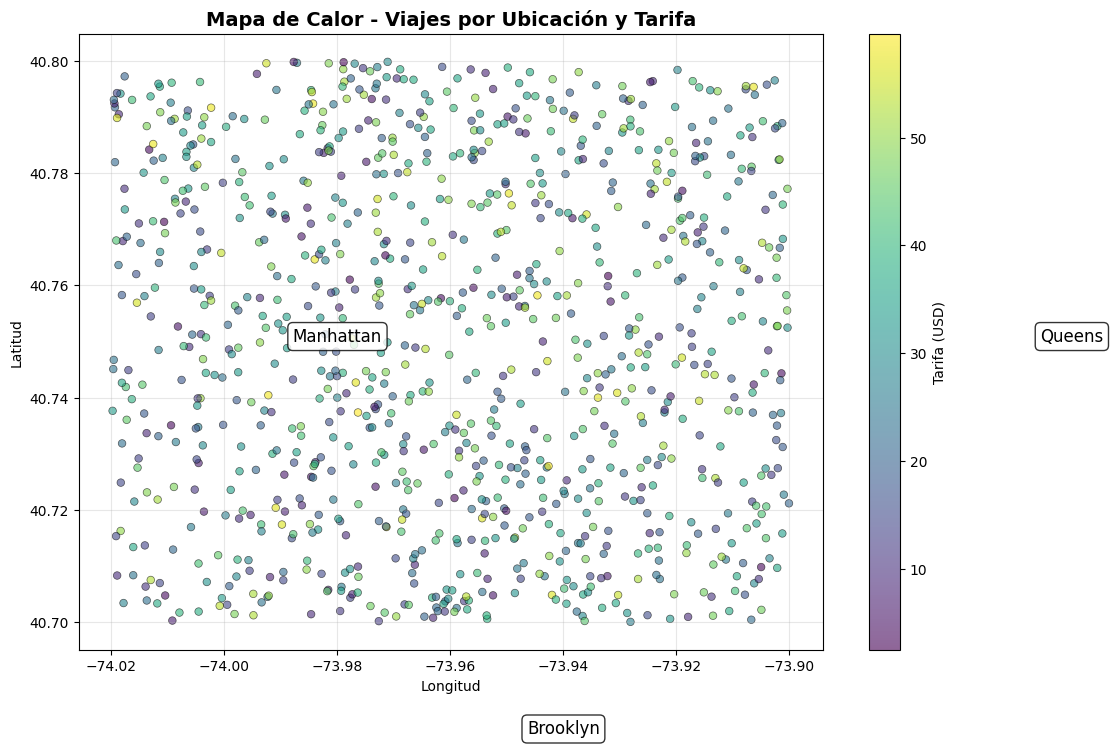

 Estadísticas Geográficas:
Rango Longitud: -74.0198 to -73.9001
Rango Latitud: 40.7000 to 40.7999


In [23]:
# Análisis geográfico
if 'df' in locals():
    plt.figure(figsize=(12, 8))
    
    # Scatter plot de ubicaciones con tarifas
    scatter = plt.scatter(df['pickup_longitude'], 
                         df['pickup_latitude'], 
                         c=df['fare_amount'], 
                         cmap='viridis', 
                         alpha=0.6,
                         s=30,
                         edgecolors='black',
                         linewidth=0.5)
    
    plt.colorbar(scatter, label='Tarifa (USD)')
    plt.title('Mapa de Calor - Viajes por Ubicación y Tarifa', fontsize=14, fontweight='bold')
    plt.xlabel('Longitud')
    plt.ylabel('Latitud')
    plt.grid(True, alpha=0.3)
    
    # Añadir anotaciones para NYC
    plt.text(-73.98, 40.75, 'Manhattan', fontsize=12, ha='center', 
             bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
    plt.text(-73.94, 40.68, 'Brooklyn', fontsize=12, ha='center',
             bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
    plt.text(-73.85, 40.75, 'Queens', fontsize=12, ha='center',
             bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
    
    plt.show()
    
    # Estadísticas geográficas
    print(" Estadísticas Geográficas:")
    print(f"Rango Longitud: {df['pickup_longitude'].min():.4f} to {df['pickup_longitude'].max():.4f}")
    print(f"Rango Latitud: {df['pickup_latitude'].min():.4f} to {df['pickup_latitude'].max():.4f}")

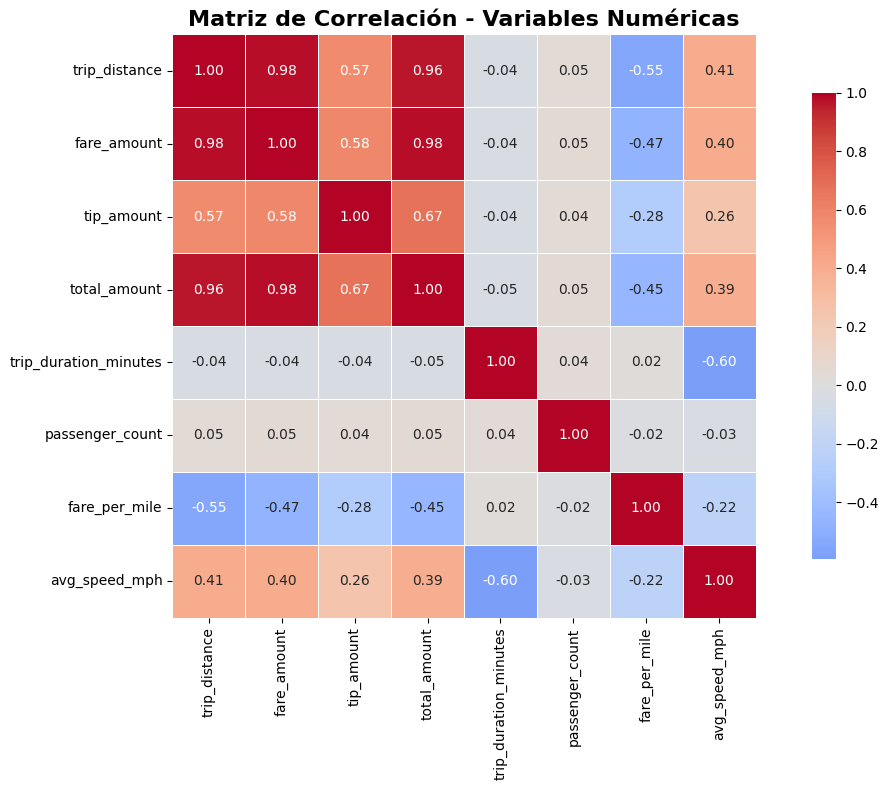

 Correlaciones más fuertes (abs > 0.5):


fare_amount            trip_distance            0.981235
trip_distance          fare_amount              0.981235
fare_amount            total_amount             0.976938
total_amount           fare_amount              0.976938
                       trip_distance            0.958066
trip_distance          total_amount             0.958066
tip_amount             total_amount             0.671447
total_amount           tip_amount               0.671447
avg_speed_mph          trip_duration_minutes   -0.595022
trip_duration_minutes  avg_speed_mph           -0.595022
dtype: float64

In [26]:
# Análisis de correlaciones
if 'df' in locals():
    # Seleccionar variables numéricas para correlación
    corr_columns = ['trip_distance', 'fare_amount', 'tip_amount', 'total_amount', 
                   'trip_duration_minutes', 'passenger_count', 'fare_per_mile', 'avg_speed_mph']
    
    correlation_matrix = df[corr_columns].corr()
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(correlation_matrix, 
                annot=True, 
                cmap='coolwarm', 
                center=0,
                square=True,
                fmt='.2f',
                cbar_kws={'shrink': 0.8},
                linewidths=0.5,
                annot_kws={'size': 10})
    
    plt.title('Matriz de Correlación - Variables Numéricas', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Correlaciones más fuertes
    print(" Correlaciones más fuertes (abs > 0.5):")
    strong_corrs = correlation_matrix.unstack().sort_values(key=abs, ascending=False)
    strong_corrs = strong_corrs[strong_corrs != 1.0]  # Remover correlación consigo mismo
    display(strong_corrs[abs(strong_corrs) > 0.5].head(10))

In [28]:
# Insights y conclusiones
if 'df' in locals():
    print(" INSIGHTS PRINCIPALES Y CONCLUSIONES")
    print("=" * 50)
    
    # Métricas clave
    total_trips = len(df)
    total_revenue = df['total_amount'].sum()
    avg_fare = df['fare_amount'].mean()
    avg_tip_percentage = df['tip_percentage'].mean()
    avg_speed = df['avg_speed_mph'].mean()
    weekend_trips = df['is_weekend'].sum()
    
    # Hora pico
    peak_hour = hourly_stats.loc[hourly_stats['trip_count'].idxmax()]
    
    print(f" Hora pico: {int(peak_hour['pickup_hour'])}:00 - {int(peak_hour['trip_count'])} viajes")
    print(f" Ingreso total: ${total_revenue:,.2f}")
    print(f" Tarifa promedio: ${avg_fare:.2f}")
    print(f" Propina promedio: {avg_tip_percentage:.1f}%")
    print(f" Velocidad promedio: {avg_speed:.1f} mph")
    print(f" Viajes fin de semana: {weekend_trips} ({weekend_trips/total_trips*100:.1f}%)")
    print(f"  Duración promedio: {df['trip_duration_minutes'].mean():.1f} minutos")
    print(f" Pasajeros promedio: {df['passenger_count'].mean():.1f}")
    
    # Métodos de pago
    payment_counts = df['payment_type'].value_counts()
    credit_card_pct = (payment_counts.get(1, 0) / total_trips) * 100
    cash_pct = (payment_counts.get(2, 0) / total_trips) * 100
    
    print(f" Pagos con tarjeta: {credit_card_pct:.1f}%")
    print(f" Pagos en efectivo: {cash_pct:.1f}%")
    
    print("\n RECOMENDACIONES OPERACIONALES:")
    print("   •  Aumentar flota en horario pico ({}:00)".format(int(peak_hour['pickup_hour'])))
    print("   •  Optimizar tarifas en horas de alta demanda")
    print("   •  Fomentar pagos con tarjeta (mayores propinas)")
    print("   •   Analizar zonas de alta demanda para mejor cobertura")
    print("   •   Monitorear duraciones para optimizar rutas")
    
    print("\n Análisis completado exitosamente!")
    
    # Mostrar métricas de negocio si están disponibles
    if 'business_metrics' in data:
        print("\n MÉTRICAS DE NEGOCIO DESDE ETL:")
        for metric, value in data['business_metrics'][0].items():
            print(f"   {metric}: {value}")

 INSIGHTS PRINCIPALES Y CONCLUSIONES
 Hora pico: 14:00 - 53 viajes
 Ingreso total: $35,730.35
 Tarifa promedio: $30.43
 Propina promedio: 10.1%
 Velocidad promedio: 18.0 mph
 Viajes fin de semana: 292 (29.2%)
  Duración promedio: 61.1 minutos
 Pasajeros promedio: 3.5
 Pagos con tarjeta: 71.9%
 Pagos en efectivo: 22.9%

 RECOMENDACIONES OPERACIONALES:
   •  Aumentar flota en horario pico (14:00)
   •  Optimizar tarifas en horas de alta demanda
   •  Fomentar pagos con tarjeta (mayores propinas)
   •   Analizar zonas de alta demanda para mejor cobertura
   •   Monitorear duraciones para optimizar rutas

 Análisis completado exitosamente!


In [31]:
# Guardar análisis procesado
if 'df' in locals():
    try:
        # Importaciones necesarias
        from datetime import datetime
        import json
        import os
        
        # Crear directorio si no existe
        os.makedirs('../data/processed/', exist_ok=True)
        
        # Guardar DataFrame con features
        df.to_csv('../data/processed/analysis_ready_data.csv', index=False)
        print(" analysis_ready_data.csv guardado")
        
        # Guardar métricas resumidas
        summary_metrics = {
            'total_trips': int(len(df)),
            'total_revenue': float(df['total_amount'].sum()),
            'avg_fare': float(df['fare_amount'].mean()),
            'avg_tip_percentage': float(df['tip_percentage'].mean()),
            'avg_trip_duration': float(df['trip_duration_minutes'].mean()),
            'avg_passengers': float(df['passenger_count'].mean()),
            'peak_hour': int(peak_hour['pickup_hour']),
            'peak_hour_trips': int(peak_hour['trip_count']),
            'weekend_trips_percentage': float((df['is_weekend'].sum() / len(df)) * 100),
            'analysis_timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        }
        
        with open('../data/processed/analysis_summary.json', 'w', encoding='utf-8') as f:
            json.dump(summary_metrics, f, indent=2, ensure_ascii=False)
        
        print(" analysis_summary.json guardado")
        
        # También guardar métricas horarias
        hourly_stats.to_csv('../data/processed/hourly_metrics_pandas.csv', index=False)
        print(" hourly_metrics_pandas.csv guardado")
        
        print("\n Archivos guardados en: data/processed/")
        print("   - analysis_ready_data.csv (datos completos con features)")
        print("   - analysis_summary.json (métricas principales)")
        print("   - hourly_metrics_pandas.csv (métricas por hora)")
        
    except Exception as e:
        print(f"  No se pudieron guardar los archivos: {e}")
        print(" Ejecuta primero: python run_etl.py para crear la estructura de carpetas")

 analysis_ready_data.csv guardado
 analysis_summary.json guardado
 hourly_metrics_pandas.csv guardado

 Archivos guardados en: data/processed/
   - analysis_ready_data.csv (datos completos con features)
   - analysis_summary.json (métricas principales)
   - hourly_metrics_pandas.csv (métricas por hora)
